#Kepler's Exoplanet Signal Review System

###In this project, we built a machine learning–based decision-support system to prioritize exoplanet signals detected by NASA’s Kepler mission. A multi-class classification model was trained to distinguish between false positives, candidate signals, and confirmed planets. To reduce manual review effort while maintaining scientific safety, we designed a threshold-based prioritization strategy using predicted confirmation probabilities. The final system retains a high proportion of confirmed planets while significantly reducing the number of signals requiring human review, and is deployed as an interactive application for real-time decision support.

#Technology used:

*   Multi-Class Classification
*   Thresholding System Design



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
np.random.seed(42)
random.seed(42)

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Importing necessary libraries

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings
import xgboost as xgb
import gradio as gr

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("cumulative.csv")

## Data Exploration and Cleaning

In [ ]:
df.head(7)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [ ]:
df.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


### Checking for NULL values

In [ ]:
df.isnull().sum()

,0
rowid,0
kepid,0
kepoi_name,0
kepler_name,7270
koi_disposition,0
koi_pdisposition,0
koi_score,1510
koi_fpflag_nt,0
koi_fpflag_ss,0
koi_fpflag_co,0


In [ ]:
df = df.drop(['koi_teq_err1','koi_teq_err2'],axis=1)

In [ ]:
df['kepler_name'].unique()

array(['Kepler-227 b', 'Kepler-227 c', nan, ..., 'Kepler-92 d',
       'Kepler-1494 b', 'Kepler-1600 b'], dtype=object)

In [ ]:
df = df.drop('kepler_name',axis=1)

 ### Label Encoding Target Variable


In [ ]:
le = LabelEncoder()
df['koi_disposition'] = le.fit_transform(df['koi_disposition'])
print(le.classes_)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']


{'CANDIDATE': np.int64(0),
 'CONFIRMED': np.int64(1),
 'FALSE POSITIVE': np.int64(2)}

### Saving our Label Encoder

In [ ]:
import joblib
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

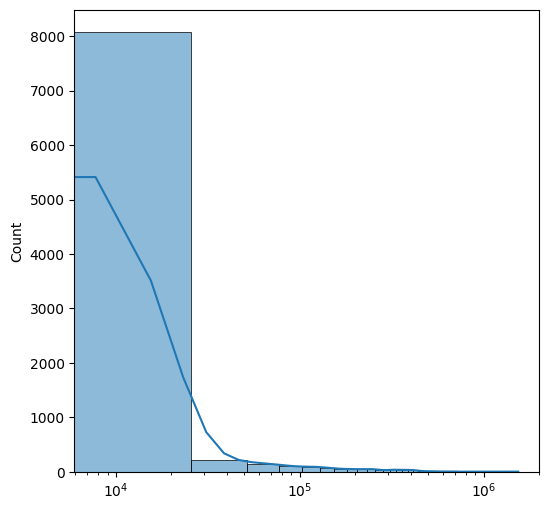

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(df['koi_depth'].values,bins=60,kde=True)
plt.xscale('log')

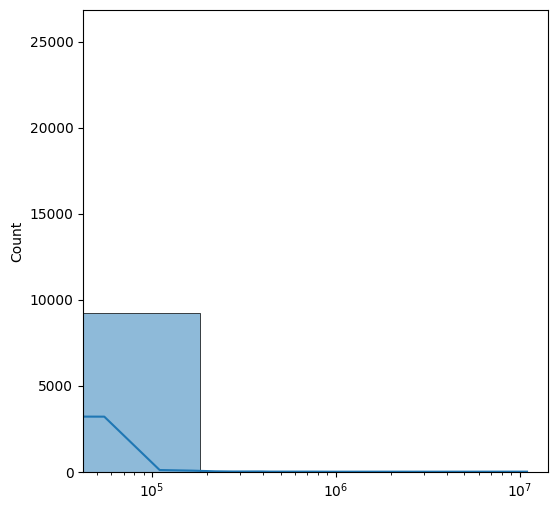

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(df['koi_insol'].values,bins=60,kde=True)
plt.xscale('log')

### In the above two plots , we can see that the KDE plot is SKEWED , we will use 'median' in Simple **Imputer**

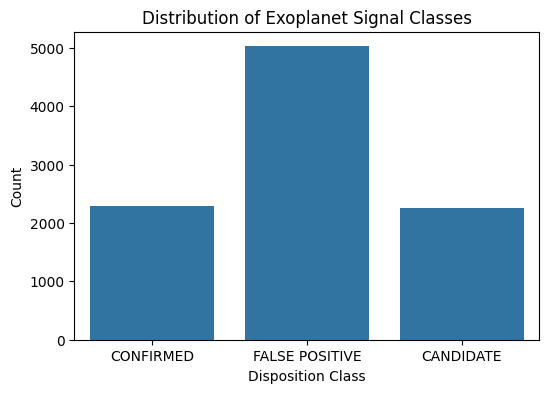

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['koi_disposition'].map(dict(enumerate(le.classes_))))
plt.xlabel("Disposition Class")
plt.ylabel("Count")
plt.title("Distribution of Exoplanet Signal Classes")
plt.show()

In [ ]:
 X = df[['koi_period',
'koi_time0bk',
'koi_duration',
'koi_depth',
'koi_impact',
'koi_model_snr',
'koi_prad',
'koi_teq',
'koi_insol',
'koi_steff',
]]
y = df['koi_disposition']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [ ]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
joblib.dump(imputer,'imputer.joblib')

['imputer.joblib']

### General function to be used for 3 models

In [ ]:
def general(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))

# Model Training and Testing the results

## Logistic Regression

In [ ]:
pipe = Pipeline([('scaler',StandardScaler()),('model_lr',LogisticRegression(random_state=42))])
param_grid = {'model_lr__C':[0.001,0.01,0.1,1,10,100],'model_lr__penalty':['l1','l2']}
grid_lr = GridSearchCV(pipe,param_grid,cv=cv)

In [ ]:
general(grid_lr,X_train,X_test,y_train,y_test)

0.6299006795608991
              precision    recall  f1-score   support

           0       0.46      0.08      0.14       449
           1       0.51      0.68      0.58       459
           2       0.70      0.85      0.77      1005

    accuracy                           0.63      1913
   macro avg       0.56      0.54      0.50      1913
weighted avg       0.60      0.63      0.58      1913



### A multinomial logistic regression model was trained as a baseline. The model performs well in identifying clear false positives but struggles with the ambiguous candidate class, indicating that non-linear decision boundaries are required. This motivates the use of tree-based models.

## Random Forest

In [ ]:
model_rf = RandomForestClassifier(random_state=42,n_jobs=-1)
param_grid = {'n_estimators':[1,5,10],'max_depth':[1,5,10],'min_samples_split':[2,5,10]}
grid_rf = GridSearchCV(model_rf,param_grid,cv=cv,scoring='f1_macro')

In [ ]:
general(grid_rf,X_train,X_test,y_train,y_test)

0.7642446419236801
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       449
           1       0.74      0.84      0.79       459
           2       0.83      0.86      0.84      1005

    accuracy                           0.76      1913
   macro avg       0.73      0.73      0.72      1913
weighted avg       0.76      0.76      0.76      1913



### We used Random Forest to introduce non - linear classification since Random Forest captures non - linear relationships well and help in reducing overfitting

## XG Boost

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=42,n_jobs=1)
param_grid = {'n_estimators':[1,5,10],'max_depth':[1,5,10],'learning_rate':[0.01,0.1,1]}
grid_xgb = GridSearchCV(model_xgb,param_grid,cv=cv,scoring='f1_macro')

In [ ]:
general(grid_xgb,X_train,X_test,y_train,y_test)

0.7600627286983795
              precision    recall  f1-score   support

           0       0.59      0.46      0.52       449
           1       0.74      0.83      0.78       459
           2       0.82      0.86      0.84      1005

    accuracy                           0.76      1913
   macro avg       0.72      0.72      0.71      1913
weighted avg       0.75      0.76      0.75      1913



### We used XG Boost since this model is a well used ensemble technique

### We trained and tested the results of 3 models


*   Logistic Regression ( Base line )
*   Random Forest (Ensemble)
*   XG Boost(Ensemble,more advanced)

### As we can see XG Boost performed better overall since it has not only highest accuracy but also recall

### Therefore , Model selected = XG Boost





In [ ]:
joblib.dump(grid_xgb,'model.joblib')

['model.joblib']

In [ ]:
class_names = le.classes_
prob = pd.DataFrame(grid_xgb.predict_proba(X_test),columns=class_names,index=y_test.index)

In [ ]:
p_Confirmed = prob['CONFIRMED']
thresholds = np.linspace(0.1,0.9,9)
results = []
for t in thresholds:
  reviewed = p_Confirmed >= t
  review_rate = reviewed.mean()
  confirmed_mask = (y_test == le.transform(['CONFIRMED'])[0])
  confirmed_recall = (reviewed & confirmed_mask).sum() / confirmed_mask.sum()
  results.append({
      'threshold':t,
      'review_rate':review_rate,
      'confirmed_recall':confirmed_recall
  })
  results_df = pd.DataFrame(results)

In [ ]:
results_df

,threshold,review_rate,confirmed_recall
0,0.1,0.399373,0.962963
1,0.2,0.332462,0.919390
2,0.3,0.302666,0.884532
3,0.4,0.272870,0.840959
4,0.5,0.244642,0.779956
5,0.6,0.210664,0.701525
6,0.7,0.165186,0.599129
7,0.8,0.123366,0.453159
8,0.9,0.042342,0.165577


### Based on the trade-off analysis, a probability threshold of 0.3 was selected as it balances safety and efficiency. At this threshold, the system retains approximately 89% of confirmed planets while reducing manual review workload by nearly 68%. This operating point aligns with industry practices, where high recall is prioritized while achieving meaningful workload reduction.

In [ ]:
threshold = 0.3
p_Confirmed = prob['CONFIRMED']
reviewed = p_Confirmed >= threshold
review_rate = reviewed.mean()
confirmed_mask = (y_test == le.transform(['CONFIRMED'])[0])
confirmed_recall = (reviewed & confirmed_mask).sum() / confirmed_mask.sum()
print("Review rate" , review_rate)
print("Recall" , confirmed_recall)
print("Workload reduction" , 1 - review_rate)

Review rate 0.30266596968112913
Recall 0.8845315904139434
Workload reduction 0.6973340303188709


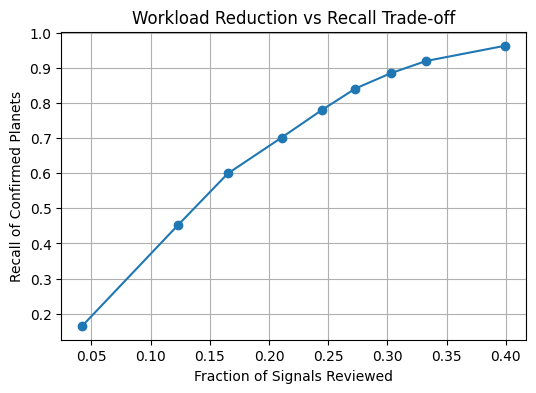

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(results_df['review_rate'],
         results_df['confirmed_recall'],
         marker='o')
plt.xlabel("Fraction of Signals Reviewed")
plt.ylabel("Recall of Confirmed Planets")
plt.title("Workload Reduction vs Recall Trade-off")
plt.grid(True)
plt.show()

In [ ]:
model = joblib.load("model.joblib")
label_encoder = joblib.load("label_encoder.joblib")
imputerJoblib = joblib.load("imputer.joblib")

CONFIRMED_LABEL = label_encoder.transform(['CONFIRMED'])[0]
THRESHOLD = 0.3

FEATURE_NAMES = [
    'koi_period',
    'koi_time0bk',
    'koi_duration',
    'koi_depth',
    'koi_impact',
    'koi_model_snr',
    'koi_prad',
    'koi_teq',
    'koi_insol',
    'koi_steff'
]


def predict_signal(*inputs):

    X = pd.DataFrame([inputs], columns=FEATURE_NAMES)

    X_imputed = imputerJoblib.transform(X)

    probs = model.predict_proba(X_imputed)[0]
    prob_dict = dict(zip(label_encoder.classes_, probs))

    p_confirmed = prob_dict['CONFIRMED']

    if p_confirmed >= THRESHOLD:
        decision = "🟢 SEND FOR REVIEW"
        explanation = (
            f"P(CONFIRMED) = {p_confirmed:.2f} ≥ {THRESHOLD}. "
            "This signal should be reviewed by scientists."
        )
    else:
        decision = "🔴 SKIP (LOW PRIORITY)"
        explanation = (
            f"P(CONFIRMED) = {p_confirmed:.2f} < {THRESHOLD}. "
            "This signal is low priority for manual review."
        )

    return (
        decision,
        explanation,
        prob_dict
    )
inputs = [
    gr.Number(label=feature) for feature in FEATURE_NAMES
]

outputs = [
    gr.Text(label="Decision"),
    gr.Text(label="Explanation"),
    gr.JSON(label="Class Probabilities")
]

app = gr.Interface(
    fn=predict_signal,
    inputs=inputs,
    outputs=outputs,
    title="Kepler Exoplanet Signal Review System",
    description=(
        "This application uses a trained ML model to prioritize Kepler "
        "telescope signals for human review. A probability threshold of 0.3 "
        "was selected offline to reduce manual workload while retaining most "
        "confirmed planets."
    ),
    allow_flagging="never"
)

app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f23e9b87d77cda971d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
%%writefile app.py
import joblib
import gradio as gr
import pandas as pd
model = joblib.load("model.joblib")
label_encoder = joblib.load("label_encoder.joblib")
imputerJoblib = joblib.load("imputer.joblib")

CONFIRMED_LABEL = label_encoder.transform(['CONFIRMED'])[0]
THRESHOLD = 0.3

FEATURE_NAMES = [
    'koi_period',
    'koi_time0bk',
    'koi_duration',
    'koi_depth',
    'koi_impact',
    'koi_model_snr',
    'koi_prad',
    'koi_teq',
    'koi_insol',
    'koi_steff'
]


def predict_signal(*inputs):

    X = pd.DataFrame([inputs], columns=FEATURE_NAMES)

    X_imputed = imputerJoblib.transform(X)

    probs = model.predict_proba(X_imputed)[0]
    prob_dict = dict(zip(label_encoder.classes_, probs))

    p_confirmed = prob_dict['CONFIRMED']

    if p_confirmed >= THRESHOLD:
        decision = "🟢 SEND FOR REVIEW"
        explanation = (
            f"P(CONFIRMED) = {p_confirmed:.2f} ≥ {THRESHOLD}. "
            "This signal should be reviewed by scientists."
        )
    else:
        decision = "🔴 SKIP (LOW PRIORITY)"
        explanation = (
            f"P(CONFIRMED) = {p_confirmed:.2f} < {THRESHOLD}. "
            "This signal is low priority for manual review."
        )

    return (
        decision,
        explanation,
        prob_dict
    )
inputs = [
    gr.Number(label=feature) for feature in FEATURE_NAMES
]

outputs = [
    gr.Text(label="Decision"),
    gr.Text(label="Explanation"),
    gr.JSON(label="Class Probabilities")
]

app = gr.Interface(
    fn=predict_signal,
    inputs=inputs,
    outputs=outputs,
    title="Kepler Exoplanet Signal Review System",
    description=(
        "This application uses a trained ML model to prioritize Kepler "
        "telescope signals for human review. A probability threshold of 0.3 "
        "was selected offline to reduce manual workload while retaining most "
        "confirmed planets."
    ),
)

app.launch()

Overwriting app.py


In [ ]:
%%writefile requirements.txt
gradio
numpy
pandas
scikit-learn == 1.6.1
joblib == 1.5.3
xgboost

Overwriting requirements.txt
